<a href="https://colab.research.google.com/github/victoriaPaez/MujeresDigitales2021/blob/main/Taller_semana_9_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de pagos a préstamos

## Introducción

**Contexto comercial.** Como analista de un banco se le entrega un conjunto de datos con información de los clientes y si pagaron el crédito o no. Su jefe le pida que entrene algunos modelos para responder la pregunta: si un usuario incurrirá en incumplimiento o no. El algoritmo para predecir la probabilidad de incumplimiento es el núcleo del negocio.

**Problema comercial.** Su tarea es **crear un modelo de clasificación para determinar si un usuario incumplirá con su préstamo o no**.

**Contexto analítico.** Como científico de datos, ahora debe concentrarse en perfeccionar el algoritmo de clasificación. Debe verificar cuantitativamente que el algoritmo funcionará para datos futuros. Además, debe expandir su conjunto de herramientas para no depender únicamente de la regresión logística, ya que tiene algunas deficiencias que se manejan mejor con otros tipos de modelos. 

## Evaluar los diferentes modelos

In [986]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [987]:
df = pd.read_csv("Lending_club_cleaned_2.csv")

In [988]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B


In [989]:
df.shape

(38705, 10)

## Ejercicio 1

Realice una estandarización de los datos númericos usando el promedio y la desviación estándar esto es: $(datos - promedio) / desviación\ estándar$, para las columnas ```[loan_amnt, int_rate, annual_inc]```. Y para las variables categóricas use one hot encoding ```[home_ownership, purpose, grade, loan_status]```.

Tip: Para las variables categóricas recuerde que puede usar la función de pandas: get_dummies

In [990]:
# copiamos el dataframe para no alterar el dataframe original
dfN=df.copy()
dfN.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B


In [991]:
dfN["int_rate"] = dfN["int_rate"].str.rstrip('%').astype('float')

In [992]:
dfN[['loan_amnt', 'int_rate', 'annual_inc']] = StandardScaler().fit_transform(dfN[['loan_amnt', 'int_rate', 'annual_inc']])
dfN.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,-0.710299,Verified,10+ years,RENT,-0.378959,-0.843873,credit_card,36 months,B
1,Charged Off,-0.616874,Source Verified,< 1 year,RENT,0.863154,-1.178535,car,60 months,C
2,Fully Paid,-0.893224,Not Verified,10+ years,RENT,1.048665,-1.191921,small_business,36 months,C
3,Fully Paid,-0.317916,Source Verified,10+ years,RENT,0.384591,-0.174548,other,36 months,C
4,Fully Paid,0.161663,Source Verified,1 year,RENT,0.169507,-1.111602,other,60 months,B


In [993]:
dfN.describe()

,annual_inc,int_rate,loan_amnt
count,3.870500e+04,3.870500e+04,3.870500e+04
mean,2.665539e-16,-2.925220e-15,-1.168688e-14
std,1.000013e+00,1.000013e+00,1.000013e+00
min,-1.021714e+00,-1.785073e+00,-1.446264e+00
25%,-4.378730e-01,-7.365365e-01,-7.769401e-01
50%,-1.497517e-01,-5.364331e-02,-1.745485e-01
75%,2.114899e-01,6.803325e-01,4.947756e-01
max,9.234054e+01,3.368889e+00,3.172072e+00


In [994]:
dfN.dtypes

loan_status             object
annual_inc             float64
verification_status     object
emp_length              object
home_ownership          object
int_rate               float64
loan_amnt              float64
purpose                 object
term                    object
grade                   object
dtype: object

In [995]:
#seleccionamos las columas que estamos interesados 
dfN=dfN[['loan_status','annual_inc','int_rate','loan_amnt','home_ownership','purpose','grade']]
dfN.head()

,loan_status,annual_inc,int_rate,loan_amnt,home_ownership,purpose,grade
0,Fully Paid,-0.710299,-0.378959,-0.843873,RENT,credit_card,B
1,Charged Off,-0.616874,0.863154,-1.178535,RENT,car,C
2,Fully Paid,-0.893224,1.048665,-1.191921,RENT,small_business,C
3,Fully Paid,-0.317916,0.384591,-0.174548,RENT,other,C
4,Fully Paid,0.161663,0.169507,-1.111602,RENT,other,B


In [996]:
# Encoding las variables categoricas no numericas 
dfN2 = pd.get_dummies(dfN, columns=['purpose', 'grade'], drop_first=False)
dfN2 = pd.get_dummies(dfN2, columns=['home_ownership'], drop_first=True)
dfN2.replace({'loan_status': {"Charged Off":0, "Fully Paid":1},}, inplace=True)
dfN2.head(5)

,loan_status,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,1,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,1,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Ejercicio 1.1:

Realice una separación de los datos: entrenamiento 80% y prueba 20%

In [997]:
X=dfN2[['annual_inc','int_rate','loan_amnt','purpose_car', 'purpose_credit_card',  'purpose_debt_consolidation', 'purpose_educational','purpose_home_improvement', 'purpose_house',  'purpose_major_purchase', 'purpose_medical',  'purpose_moving', 'purpose_other' ,'purpose_renewable_energy',  'purpose_small_business', 'purpose_vacation', 'purpose_wedding',  'grade_A',  'grade_B',  'grade_C' ,'grade_D', 'grade_E' ,'grade_F','grade_G']]
X.head(5)

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [998]:
y = dfN2[['loan_status']].values.ravel()
y

array([1, 0, 1, ..., 1, 1, 1])

In [999]:
# Split Train, Validation y Test Data separacion de los datos: entrenamiento 80% y prueba 20%
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

In [1000]:
print("X_train", X_train.shape)
print("X_vali",X_vali.shape)
print("X_test",X_test.shape)
print("y_test",X_test.shape)

X_train (24771, 24)
X_vali (6193, 24)
X_test (7741, 24)
y_test (7741, 24)


## Ejercicio 2:

Entrene 3 modelos para predecir si un cliente pagará el crédito o no:
1. Regresión logística
2. Árbol aleatorio (random forest)
3. KNN (vecinos mas cercanos)

## Ejercicio 3:

Compare los tres modelos anteriores usando la métrica precisión. Recuerde que la fórmula es: $VP/(VP+FP)$

Donde:


VP: Verdaderos positivos

FP: Falsos positivos

# Ejercicio 2 Regresión logística 

In [1001]:
X.head(5)

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [1002]:
y

array([1, 0, 1, ..., 1, 1, 1])

In [1003]:
#Entrenamos un modelo de regresión logística
#importamos la clase LogisticRegresion de scikit-learn
from sklearn.linear_model import LogisticRegression

In [1004]:
# Creamos una instancia de la Regresión Logística
regresion_logistica = LogisticRegression()

In [1005]:
#Entrenamos la regresión logística con los datos de entrenamiento
regresion_logistica.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [1006]:
X_nuevo = X_vali

In [1007]:
# Usa el modelo entrenado para obtener las predicciones con datos nuevos

prediccion = regresion_logistica.predict(X_nuevo)
print(prediccion)

[1 1 1 ... 1 1 1]


In [1008]:
#obtenemos las probabilidades de la predicción
probabilidades_prediccion = regresion_logistica.predict_proba(X_nuevo)
print(probabilidades_prediccion)

[[0.23183173 0.76816827]
 [0.09970795 0.90029205]
 [0.04334627 0.95665373]
 ...
 [0.06635037 0.93364963]
 [0.14780211 0.85219789]
 [0.33880729 0.66119271]]


In [1009]:
# Como seguramente estamos más interesados en la probabilidad de aprobar, podemos centrarnos en la segunda columna
print(probabilidades_prediccion[:,1])

[0.76816827 0.90029205 0.95665373 ... 0.93364963 0.85219789 0.66119271]


In [1010]:
intercepto=regresion_logistica.intercept_
intercepto[0]

1.893447077133691

In [1011]:
beta1=regresion_logistica.coef_
beta1[0][0]

0.38735875757240024

In [1012]:
X1=dfN2['loan_amnt'].unique()

In [1013]:
import pandas as pd
dfu= pd.DataFrame()
dfu['X']=X1
dfu['X_predicho']=dfu['X']*beta1[0][0]+ intercepto[0] # Calculo de los valores de X para la funcion Sigmoide
dfu['Probabilidades']=1/(1+np.exp(-dfu.X_predicho)) # Calculo de probabilidades 
dfu

,X,X_predicho,Probabilidades
0,-0.843873,1.566566,0.827293
1,-1.178535,1.436931,0.807979
2,-1.191921,1.431746,0.807173
3,-0.174548,1.825834,0.861265
4,-1.111602,1.462858,0.811969
...,...,...,...
875,-1.406105,1.348780,0.793930
876,-0.131042,1.842687,0.863266
877,0.230393,1.982692,0.878968
878,1.478682,2.466227,0.921740


In [1014]:
dfu.describe()

,X,X_predicho,Probabilidades
count,880.000000,880.000000,880.000000
mean,0.296112,2.008149,0.874350
std,1.131529,0.438308,0.043630
min,-1.446264,1.333224,0.791373
25%,-0.633872,1.647911,0.838609
50%,0.131667,1.944450,0.874840
75%,1.073741,2.309370,0.909650
max,3.172072,3.122177,0.957798


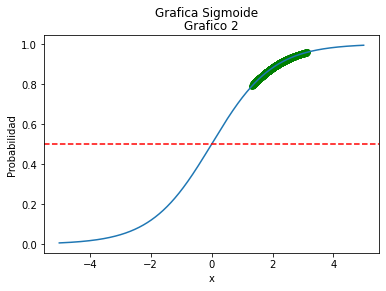

In [1015]:
import matplotlib.pyplot as plt
import math
def sigmoid(x):
  a=[]
  for item in x:
    a.append(1/(1+math.exp(-item)))
  return a
x= np.arange(-5,5,0.01)
sig=sigmoid(x)
plt.plot(x,sig)
plt.axhline(y=0.5, color='r',linestyle='--')
plt.xlabel('x')
plt.ylabel('Probabilidad')
plt.title('Grafico 2')
plt.suptitle('Grafica Sigmoide')
plt.scatter(dfu.X_predicho,dfu.Probabilidades,color='g')

In [1016]:
#SE TIENE APROXIMADAMENTE ENTRE UN 88% A UN 90% DE FACTIBILIDAD QUE LOS CLIENTES PAGARAN LOS CREDITOS

# EJERCICIO 3 Regresión logística  - métrica precisión.

In [1017]:
lo_pred=regresion_logistica.predict(X_test)

In [1018]:
from sklearn.metrics import precision_score
precision_score(y_test, lo_pred)

0.8672097232997156

In [1019]:
#CON LA METRICA DE PRESICION SE TIENE APROXIMADAMENTE UN 87% DE FACTIBILIDAD QUE LOS CLIENTES PAGARAN LOS CREDITOS

#Ejercicio 2 Árbol aleatorio (random forest) 

In [1020]:
#Carga de las librerías
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [1021]:
dfN2.head(5)

,loan_status,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,1,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,1,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [1022]:
dfN2.shape

(38705, 28)

In [1023]:
dfN2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_status                 38705 non-null  int64  
 1   annual_inc                  38705 non-null  float64
 2   int_rate                    38705 non-null  float64
 3   loan_amnt                   38705 non-null  float64
 4   purpose_car                 38705 non-null  uint8  
 5   purpose_credit_card         38705 non-null  uint8  
 6   purpose_debt_consolidation  38705 non-null  uint8  
 7   purpose_educational         38705 non-null  uint8  
 8   purpose_home_improvement    38705 non-null  uint8  
 9   purpose_house               38705 non-null  uint8  
 10  purpose_major_purchase      38705 non-null  uint8  
 11  purpose_medical             38705 non-null  uint8  
 12  purpose_moving              38705 non-null  uint8  
 13  purpose_other               387

In [1024]:
dfN2.isnull().sum()

loan_status                   0
annual_inc                    0
int_rate                      0
loan_amnt                     0
purpose_car                   0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_house                 0
purpose_major_purchase        0
purpose_medical               0
purpose_moving                0
purpose_other                 0
purpose_renewable_energy      0
purpose_small_business        0
purpose_vacation              0
purpose_wedding               0
grade_A                       0
grade_B                       0
grade_C                       0
grade_D                       0
grade_E                       0
grade_F                       0
grade_G                       0
home_ownership_OTHER          0
home_ownership_OWN            0
home_ownership_RENT           0
dtype: int64

In [1025]:
X = dfN2.drop(['loan_status'], axis=1)
y = dfN2[['loan_status']]

In [1026]:
X

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38700,0.628786,-1.072606,-1.178535,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38701,-0.803723,-0.478435,-0.375346,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
38702,0.473079,-1.072606,-0.843873,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38703,2.030154,-1.244674,-0.843873,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [1027]:
y

,loan_status
0,1
1,0
2,1
3,1
4,1
...,...
38700,1
38701,1
38702,1
38703,1


In [1028]:
#Separamos en train y test!
(X_train, X_test,y_train, y_test) = train_test_split(X,y,stratify=y,test_size=0.30,random_state=42)

In [1029]:
#Creamos un arbol de decisión sencillo y lo fiteamos
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [1030]:
X_test

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
17244,0.083810,-0.354762,-0.576143,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26652,-0.289888,-0.153120,1.833424,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2384,-0.071898,1.266438,0.093181,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
21708,-0.305459,-1.384479,-0.843873,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
26351,-0.367742,-0.053643,-0.710008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23941,-0.430025,1.145453,-1.245467,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4629,-0.672929,0.169507,0.253819,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5895,0.317371,-1.621071,-0.710008,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5607,-0.124044,1.484211,0.494776,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [1031]:
y_test

,loan_status
17244,1
26652,1
2384,1
21708,1
26351,1
...,...
23941,0
4629,1
5895,1
5607,1


In [1032]:
y_test_pred = tree.predict(X_test) #Prediccion en Test
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [1033]:
from sklearn.metrics import accuracy_score

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de evaluación: 0.760592490527041


In [1034]:
#Creamos un random forest!
model = RandomForestClassifier(random_state=42, n_estimators=100,
                               class_weight="balanced", max_features="log2")
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [1035]:
y_test_pred = model.predict(X_test) #Prediccion en Test
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [1036]:
#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de evaluación: 0.8467102996899759


In [1037]:
#CON ACCURACY SE TIENE APROXIMADAMENTE UN 85% DE FACTIBILIDAD QUE LOS CLIENTES PAGARAN LOS CREDITOS

# Ejercicio 3: Árbol aleatorio (random forest) - métrica precisión.

In [1038]:
from sklearn.metrics import precision_score
test_score =precision_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_score)

% de aciertos sobre el set de evaluación: 0.8628318584070797


In [1039]:
#CON LA METRICA DE PRESICION SE TIENE APROXIMADAMENTE UN 86% DE FACTIBILIDAD QUE LOS CLIENTES PAGARAN LOS CREDITOS

# Ejercicio 2 KNN (vecinos mas cercanos)

In [1040]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [1041]:
X.head()

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,-0.710299,-0.378959,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,-0.616874,0.863154,-1.178535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,-0.893224,1.048665,-1.191921,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,-0.317916,0.384591,-0.174548,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.161663,0.169507,-1.111602,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [1042]:
y

,loan_status
0,1
1,0
2,1
3,1
4,1
...,...
38700,1
38701,1
38702,1
38703,1


In [1043]:
X_train

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
235,-0.352172,-0.849456,0.695573,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
32322,-0.027210,-0.247219,-0.843873,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
108,-0.305459,0.384591,-0.710008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
37584,-0.336601,-0.532206,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
33465,-0.500094,0.591610,-0.442278,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,-0.461167,0.384591,1.164100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
33492,-0.523450,-0.838702,-0.174548,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
20151,0.052668,-1.282313,0.093181,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
35142,-0.562377,0.973385,-1.178535,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [1044]:
y_train

,loan_status
235,1
32322,1
108,1
37584,1
33465,1
...,...
1722,0
33492,1
20151,1
35142,1


In [1045]:
punto_nuevo = pd.DataFrame(X_train)
punto_nuevo

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
235,-0.352172,-0.849456,0.695573,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
32322,-0.027210,-0.247219,-0.843873,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
108,-0.305459,0.384591,-0.710008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
37584,-0.336601,-0.532206,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
33465,-0.500094,0.591610,-0.442278,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,-0.461167,0.384591,1.164100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
33492,-0.523450,-0.838702,-0.174548,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
20151,0.052668,-1.282313,0.093181,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
35142,-0.562377,0.973385,-1.178535,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [1046]:
dfkn.loc[dfkn['loan_status'] == 'Fully Paid', 'loan_amnt']

0         5000
2         2400
3        10000
4         3000
5         5000
         ...  
38700     2500
38701     8500
38702     5000
38703     5000
38704     7500
Name: loan_amnt, Length: 33265, dtype: int64

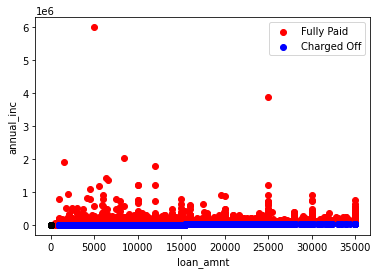

In [1047]:
ax = plt.axes()

ax.scatter(dfkn.loc[dfkn['loan_status'] == 'Fully Paid', 'loan_amnt'],df.loc[df['loan_status'] == 'Fully Paid', 'annual_inc'],c="red",label="Fully Paid")
ax.scatter(dfkn.loc[dfkn['loan_status'] == 'Charged Off', 'loan_amnt'],df.loc[df['loan_status'] == 'Charged Off', 'loan_amnt'],c="blue",label="Charged Off")
ax.scatter(punto_nuevo['loan_amnt'],punto_nuevo['annual_inc'],c="black")
plt.xlabel("loan_amnt")
plt.ylabel("annual_inc")
ax.legend()
plt.show()

In [1048]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=3)


In [1049]:
knn =KNeighborsClassifier()

In [1050]:
knn.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [1051]:
prediccion = knn.predict(punto_nuevo) 
print(prediccion)

[1 1 1 ... 1 1 1]


# EJERCICIO 3 KNN (vecinos mas cercanos) - métrica precisión.

Ejercicio 3:
Compare los tres modelos anteriores usando la métrica precisión. Recuerde que la fórmula es:  VP/(VP+FP) 

Donde:

VP: Verdaderos positivos

FP: Falsos positivos

In [1052]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [1053]:
w=df.copy()
w.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B


In [1054]:
#seleccionamos las columas que estamos interesados  
w=w[['loan_status','annual_inc','int_rate','loan_amnt','home_ownership','purpose','grade']]
w.head()

,loan_status,annual_inc,int_rate,loan_amnt,home_ownership,purpose,grade
0,Fully Paid,24000.0,10.65%,5000,RENT,credit_card,B
1,Charged Off,30000.0,15.27%,2500,RENT,car,C
2,Fully Paid,12252.0,15.96%,2400,RENT,small_business,C
3,Fully Paid,49200.0,13.49%,10000,RENT,other,C
4,Fully Paid,80000.0,12.69%,3000,RENT,other,B


In [1055]:
w["int_rate"] = w["int_rate"].str.rstrip('%').astype('float')

In [1056]:
# Encoding las variables categoricas no numericas 
dfw2 = pd.get_dummies(w, columns=['purpose', 'grade'], drop_first=False)
dfw2 = pd.get_dummies(dfw2, columns=['home_ownership'], drop_first=True)
dfw2.replace({'loan_status': {"Charged Off":0, "Fully Paid":1},}, inplace=True)
dfw2.head(5)

,loan_status,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,1,24000.0,10.65,5000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,30000.0,15.27,2500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,12252.0,15.96,2400,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,1,49200.0,13.49,10000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,80000.0,12.69,3000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [1057]:
from sklearn.neighbors import KNeighborsClassifier 

knn1 = KNeighborsClassifier(n_neighbors=3)
X =dfw2[['loan_amnt',	'annual_inc','int_rate','purpose_car',	'purpose_credit_card',	'purpose_debt_consolidation',	'purpose_educational','purpose_home_improvement',	'purpose_house',	'purpose_major_purchase',	'purpose_medical',	'purpose_moving',	'purpose_other',	'purpose_renewable_energy',	'purpose_small_business',	'purpose_vacation',	'purpose_wedding',	'grade_A',	'grade_B',	'grade_C',	'grade_D',	'grade_E',	'grade_F',	'grade_G',	'home_ownership_OTHER',	'home_ownership_OWN',	'home_ownership_RENT']]
y =dfw2[['loan_status']]
knn1.fit(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [1058]:
X

,loan_amnt,annual_inc,int_rate,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,5000,24000.0,10.65,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2500,30000.0,15.27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2400,12252.0,15.96,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,10000,49200.0,13.49,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,3000,80000.0,12.69,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38700,2500,110000.0,8.07,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38701,8500,18000.0,10.28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
38702,5000,100000.0,8.07,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38703,5000,200000.0,7.43,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [1059]:
y

,loan_status
0,1
1,0
2,1
3,1
4,1
...,...
38700,1
38701,1
38702,1
38703,1


In [1060]:
X_train

,annual_inc,int_rate,loan_amnt,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
235,-0.352172,-0.849456,0.695573,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
32322,-0.027210,-0.247219,-0.843873,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
108,-0.305459,0.384591,-0.710008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
37584,-0.336601,-0.532206,-0.843873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
33465,-0.500094,0.591610,-0.442278,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,-0.461167,0.384591,1.164100,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
33492,-0.523450,-0.838702,-0.174548,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
20151,0.052668,-1.282313,0.093181,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
35142,-0.562377,0.973385,-1.178535,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [1061]:
y_train

,loan_status
235,1
32322,1
108,1
37584,1
33465,1
...,...
1722,0
33492,1
20151,1
35142,1


In [1062]:
knn1.predict(X)[:5]

array([1, 1, 1, 1, 1])

In [1063]:
from sklearn.metrics import precision_score
precision_score(y, knn1.predict(X))

0.8961153295917245

In [1064]:
#CON LA METRICA DE PRESICION SE TIENE APROXIMADAMENTE UN 89% DE FACTIBILIDAD QUE LOS CLIENTES PAGARAN LOS CREDITOS